In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit





y01, y: 
[1 1 1 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0]
[ 1  1  1  1 -1  1  1 -1 -1  1  1  1 -1 -1 -1  1 -1 -1 -1 -1]
y_one_hot: 
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


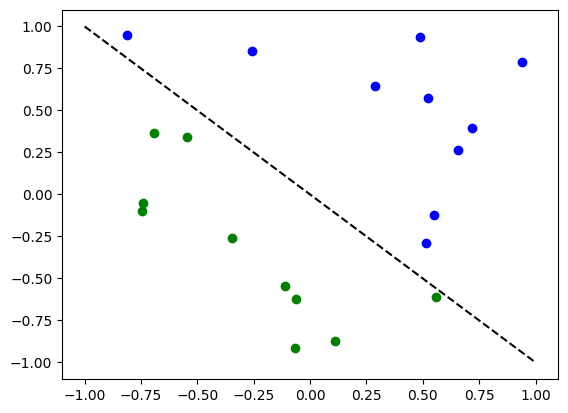

In [11]:
algorithm_globals.random_seed = 42

num_inputs = 2
num_samples = 20

'''
random.random( [샘플의 수, 입력의 수] ) : 0~1 사이의 난수로 이루어진 샘플행, 입력열 을 생성한다.
이때, 행=샘플의 수 / 열=입력의 수 이다. 

  Example output : sample = 3, input = 2 : 3행2열
X = [[ 0.5, -0.3],
     [-0.8,  0.1],
     [ 0.9, -0.7]]

2 * X - 1 : X의 모든 원소에 2를 곱하고 1을 뺀다.  :  -1 <= X <= 1
'''

X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1

'''
np.sum(X, axis=1) : X 행렬의 '열'을 따라서, 행의 합을 출력하는 배열을 생성한다.

>=0 : 각 열벡터의 원소가 0보다 크거나 같으면 True, 아니면 False를 출력한다.
즉, boolean 형태의 배열을 생성한다.

1 * (boolean) : boolean을 1로 변환한다. True -> 1, False -> 0
'''
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}

print(f'y01, y: \n{y01}\n{y}')

# 각 샘플마다 레이블 값을 one-hot encoding으로 변환한다.
y_one_hot = np.zeros((num_samples, 2))

# i번째 샘플 = i번째 행에서, y01[i]가 0이면 첫번째 열에 1을 넣고, 1이면 두번째 열에 1을 넣는다.
# 즉, y01[i] : i번째 샘플의 레이블 값 = i번째 행의 값 : [0, 1] = 1 or [1, 0] = 0
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1  


print(f'y_one_hot: \n{y_one_hot}')

# zip : 여러개의 iterable을 하나의 iterable로 묶어준다.
for x, y_target in zip(X, y):

    # y값은 -1 or 1이므로, y_target이 1이면 파란색, 0이면 초록색으로 표시한다.
    # y는 20개의 레이블, X는 20개의 좌표 샘플이므로, 각 좌표에 대한 레이블을 색으로 구분한다.
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")

### Classifier Quantum Nerual Network 구성하기

QClassifier은 3개의 파트로 구성되어 있다.
<br><br>
1. classical data를 quantum circuit에 인코딩
    - Angle encoding: Rotation gate의 각도에 데이터를 넣는방법
    - Basis encoding: Circuit의 초기 기저 $\ket{00}\,\,\ket{01}$ 등등에 데이터 점 1개를 대응시킨다.
    - Amplitude encoding : 초기 initialization에서, 각 기저의 'amplitude' 를 데이터 값으로 넣는다.

2. Circuit layer층 쌓기
    - Rotation gate, Cnot gate 등을 사용해서, parameter를 넣고 비선형적인 구조를 만들어주는 레이어를 쌓는다.

3. Measurement
    - 측정을 통해서, 결과값을 classical bit string ( SamplerQNN ) 혹은 주어진 observable의 기댓값 ( EstimatorQNN ) 으로 출력한다.
    - 여기서, parity 혹은 0을 기준으로 분류 를 통해서, 결과값을 +1 , -1로 대응시키는 이진분류를 수행한다. 

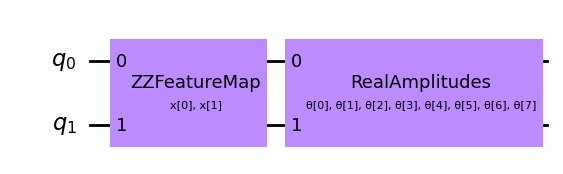

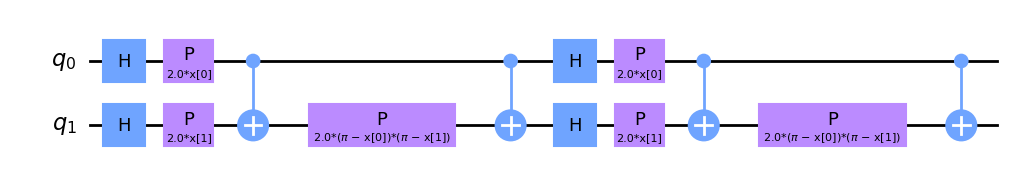

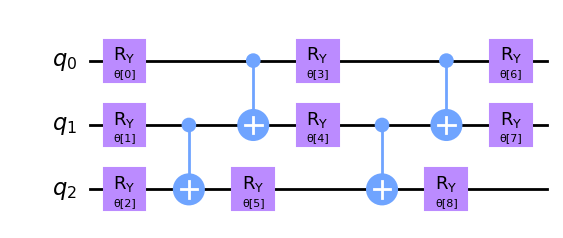

In [3]:
qc = QNNCircuit(num_qubits=2)
display(qc.draw('mpl', style='clifford'))

# data encoding via ZZFeatureMap
display(ZZFeatureMap(2, reps=2).decompose().draw('mpl', style='clifford'))

# Impose trainable parameters using RealAmplitudes
display(RealAmplitudes(3, reps=2).decompose().draw('mpl', style='clifford'))

#### Data encoding : ZZFeatureMap
Sub-class of PauliFeatureMap where the pauli strings are 'ZZ'.
$$
U_{\Phi}(\vec{x}) = \exp \left( i \sum_{S \in \mathcal{I}} \phi_S (\vec{x}) \prod_{i \in S} P_i \right).
$$
[Reference of how to encode classical data into quantum data using ZZFeaturemap; Supervised learning with quantum-enhanced feature spaces](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PauliFeatureMap)

#### Anasatz : Y gate layers and CX layer
The RealAmplitudes circuit is a heuristic trial wave function used as Ansatz in chemistry applications or classification circuits in machine learning. The circuit consists of alternating layers of YY rotations and CXCX entanglements.



#### EstimatorQNN

class EstimatorQNN(*, circuit, estimator=None, observables=None, input_params=None, weight_params=None, gradient=None, input_gradients=False, default_precision=0.015625, pass_manager=None)

The EstimatorQNN is a neural network that takes in a parametrized quantum circuit with designated parameters for input data and/or weights, an optional observable(s) ( default : observables=None = $Z^{\otimes n}$) and outputs their expectation value(s).


In [9]:
# define estimator using above dataencoding circuit.
# Estimator : evaluzte 
algorithm_globals.random_seed = 42

from qiskit.primitives import StatevectorEstimator as Estimator

estimator = Estimator()

# define the quantum neural network, obvservable = Z^n
# This network(estimator) based on the evaluation of quantum observable. ( in this case, Z^n pauli string)
estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)


# Forward calculation of the quantum neural network
random_weights = algorithm_globals.random.random(estimator_qnn.num_weights) # random weights between 0 and 1, length = estimator_qnn.num_weights
estimator_qnn.forward(X[0,:] , random_weights)  # forward calculation(input array, weights array)

'''
< forward calculation of the quantum neural network >

QNN circuit:  input data(X_coordiates) -> ZZFeatureMap ( data encoding ) -> RealAmplitudes ( trainable parameters ) 
-> Z^n ( observable ) -> output ( measure expectation value of Z^n using estimator : value : -1 ~ 1 )

: QNN circuit is a type of classifier that takes input data and returns the value from -1 to 1.


'''

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


array([[-0.45242479]])

### Define callback graph

By defining callback_graph, we can track of how loss function, weights are being updated.

this will be called for each iteration of optimizer to get a list of value of objective function.

In [10]:
def callback_graph( weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_val.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_val)), objective_func_val)
    plt.show()

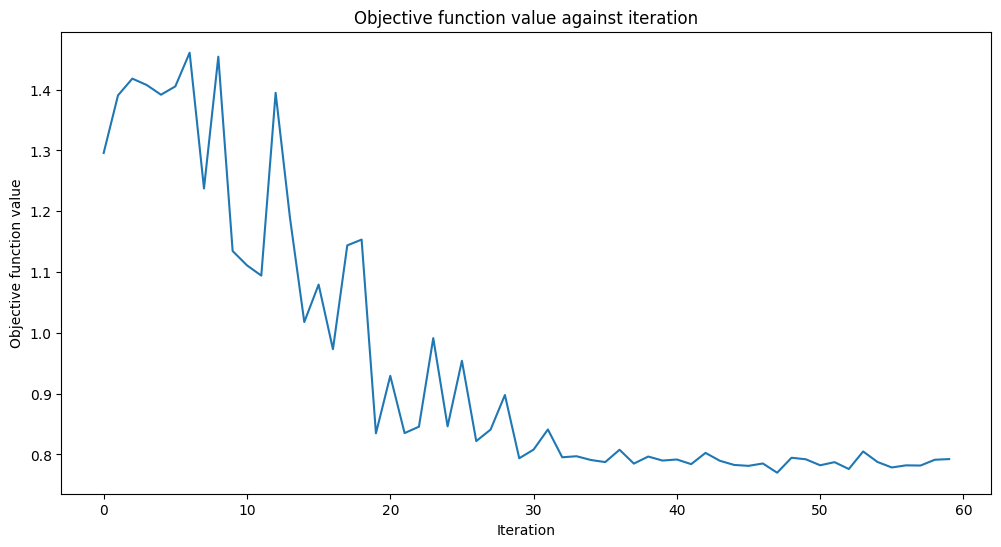

0.7

In [13]:
# construct NN classifier,  it provides the interface to train the quantum neural network.
# method : fit, predict, score ...
# default loss function = L2 loss
estimator_classifier = NeuralNetworkClassifier(neural_network=estimator_qnn,optimizer= COBYLA(maxiter=60), callback = callback_graph)

# create empty arr to store objective function value
objective_func_val = []
plt.rcParams["figure.figsize"] = (12, 6)  # configure the size of the plot

# fit the classifier to data ( using QNN and the data )
estimator_classifier.fit(X, y)
'''
Comparing the output of QNN and the target label of the data, 
'''

plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


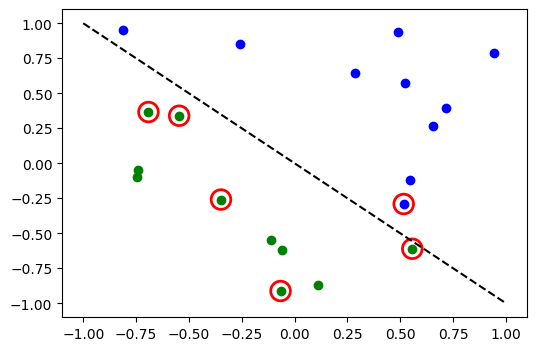

In [14]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

print(y_predict)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict): # zip : 여러개의 iterable을 하나의 iterable로 묶어준다.

    # depending on the label(y_target), plot the point with different color
    # x consists of 2 coordinates, x[0] = x-coordinate, x[1] = y-coordinate
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")  # x consists of 2 coordinates, x[0] = x-coordinate, x[1] = y-coordinate
    else:
        plt.plot(x[0], x[1], "go")
    
    # if true label is not equal to predicted label, plot the point with red color
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)

plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()